# Earthscope MsPASS Short Course 2025:  Session 1
## *Prof. Gary L. Pavlis*
## Data and Metadata
The lecture I just presented covered two topics:
1.  A high level introduction to MsPASS
2.  A brief overview of the concept of "data" and "metadata" and how the ideas are encapsulated in core data objects used in MsPASS.

This notebook is a hands on exercise to strengthen your understanding of item 2. 

## Before Running this Notebook
### Launch the database server

As noted in the PrecourseProcessing notebook, an issue we haven't been able to resolve is how to have a private instance of MongoDB launch for each instance of a geolab login.  For that reason you will need to do a shortened version of the commands you used in the PrecourseProcessing notebook.  

Launch a terminal window in GeoLab and enter these commands:
```
cd   #  makes sure you are running this in your home directory
mongod --dbpath ./db --logpath ./logs/mongo_log
```
Note a couple things that can go wrong here:
-  The command will block.  If you want to reuse that terminal window put an & at the end of the mongod launch line.
-  DO NOT exit the terminal window from which you run the mongod command or you will kill the database server.  
-  Each time you reconnect to GeoLab you will need to relaunch the MonogDB server with that  incantation. Be careful you always run the command from the same directory as that way the database files will be written to ~/db and the mongodb log will appear in ~/logs.
-  In all cases it is wise to launch a second Terminal window and erify that worked by typing `ps -A`  You should see a line where the CMD field is "mongod".   If not, contact me by email or slack if you are unable to solve the problem.  The first place to look if you are having a problem is the content of the file ~/logs/mongo_log that will be generated when this command runs.

### Use outside GeoLab
If you are accessing this notebook from github and are not part of the 2025 short course you can still run this tutorial notebook on a desktop system. To do so you will need to do two things:
1.  Install the `mspass-desktop` GUI described in __[MsPASS User's Manual here](https://www.mspass.org/getting_started/mspass_desktop.html)__
2.  Launch MsPASS as described on that page and run this notebook using the "run" button on the GUI. Alternatively, you may run it interactively by pushing the "jupyter" button.

### Preliminaries
Later in this session we will dig deeper into the database system used in MsPASS called MongoDB.   When you entered the GeoLab gateway, the gateway launched an instance of the "MongoDB server".   MongoDB, like most modern dbms systems, uses a client-server model.   The server is the gatekeeper and all interactions with the database happen through that program.  It might also be helpful to think of the MongoDB server as providing a "service" - a modern IT buzz word.   In this case, the "service" is pulling and pushing data to from and to storage managed by the database server.   We will be interacting in this session that server through a "client".  There a special object in MsPASS that is an subclass of the MongoDB client.   We can create an instance to connect to the database you created earlier with the following incantation:

In [1]:
from mspasspy.client import Client
dbclient=Client().get_database_client()

2025-07-21 11:09:48,931 - distributed.nanny - WARNING - Restarting worker
2025-07-21 11:09:48,954 - distributed.nanny - WARNING - Restarting worker
2025-07-21 11:09:49,057 - distributed.nanny - WARNING - Restarting worker
2025-07-21 11:09:49,360 - distributed.nanny - WARNING - Restarting worker
2025-07-21 11:09:50,366 - distributed.nanny - WARNING - Restarting worker


The symbol *dbclient* now contains a running instance of the "client" that is set up for interaction with the MongoDB "server".   The client itself is useful only as a mid-level manager that handles data flow with the server.  What we need to actually do something useful is create an instance of a handle to a particular database managed by the database server.   This incantation creates an instance of a MsPASS `Database` object, which we will assign the symbol *db*, that we will use for interactions with the database you created earlier.  

In [2]:
db = dbclient.get_database("Earthscope2025")

We will explore the API of the object stored in *db* later, but for now think of it as simply a handle to interact with the entire data set you prepared by running the workflow prior to the classs. 

### TimeSeries Objects
The workflow you ran before the start of this class created a complete, working data set of over 26,000 "TimeSeries objects".   A `TimeSeries` in MsPASS is an abstraction of the single channel of data in a particular time interval.   Let's just load up the first one in the data set and play with it a bit. 

In [3]:
doc = db.wf_TimeSeries.find_one()
d = db.read_data(doc)
type(d)

mspasspy.ccore.seismic.TimeSeries

First, let's do a quick visualization of the content of that object with matplotlib, which I suspect many of you are are already familiar.

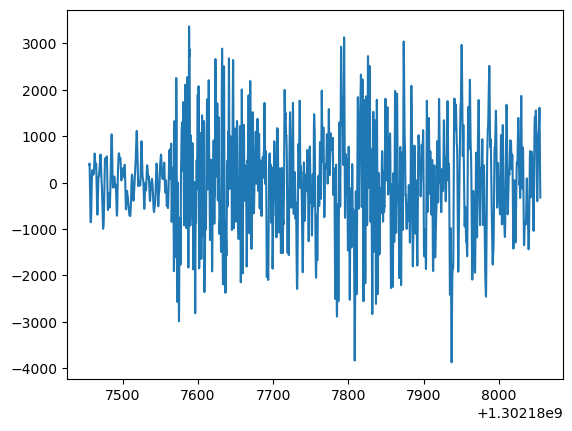

In [4]:
import matplotlib.pyplot as plt
plt.plot(d.time_axis(),d.data)
plt.show()

Two details about code segment that are informative:
1.  The `d.data` symbol is a reference to the `data` attribute of the (data) object `d`.  The visualization show the content of `data` is a vector of numbers that define this particular channel of data recording a particular teleseismic earthquake.  In MsPASS "the data" means mostly the sample data.
2.  For the plot we used a "method" of the data object, `d`, called `time_axis`.   It is a convenience method of matplotlib plots that creates a vector of the time of each sample. Note that time is displayed as the x axis rounded to the nearest second.  The time standard by default in MsPASS is "unix epoch time", which is the number of seconds elapsed since the beginning of 1970.  The issue of time in MsPASS is an important issue, but best put aside for now. __[See this section of the MsPASS User's Manual ](https://www.mspass.org/user_manual/time_standard_constraints.html)__ for details.

A `TimeSeries` object has a lot of complexity to provide the functionality needed for MsPASS, but the following code blocks shows what auxiliary data (normally called "attributes") are essential to define a particular waveform that is "data" in MsPASS:

In [5]:
from obspy import UTCDateTime
print("Number of points in the data vector is d.npts=",d.npts)
print("The sample interval is d.dt=",d.dt)
print("The data start time in epoch seconds is d.t0=",d.t0)
print("The UTC time of d.t0=",UTCDateTime(d.t0))
print("The special variable d.tref={} defines the time standard as UTC".format(d.tref))
print("It can also be set to what we call 'relative time' for active source data where t0 is normally shot time")

Number of points in the data vector is d.npts= 24001
The sample interval is d.dt= 0.025
The data start time in epoch seconds is d.t0= 1302187455.4
The UTC time of d.t0= 2011-04-07T14:44:15.400000Z
The special variable d.tref=TimeReferenceType.UTC defines the time standard as UTC
It can also be set to what we call 'relative time' for active source data where t0 is normally shot time


Everything else in a `TimeSeries` object is defined as "Metadata", which we will discuss at length below. 

### Seismogram Objects
A `Seismogram` object encapsulates the core concept of seismology of a three-component seismogram.  The concepts a `Seismogram` shares the following concepts with a `TimeSeries`:
1.  Uniform sample interval - stored with the same attribute name of *dt*.
2.  Start time is normally specified as a UTC epoch time and stored as the attribute *t0*.
3.  The number of samples is fixed for an instance of the object and is defined with the attribute *npts*.

The differences in concept are:
1.  The samples are three-component vectors defining amplitudes along three internally defined basis vectors.
2.  The object needs to store a transformation matrix to define the basis vectors each component scales.

The later is admittedly abstract, but necessary to define the generic concept.  The abstraction is needed because some data is "cardinal", meaning orieted so that the components are x1= +East, x2= + North, and x3 = +Up, but during processing that is not necessarily true.  e.g. in the receiver function processing we will do in session 2 we will apply Kennett's free surface tranformation operator that transforms the data into a non-orthonal system of approximate P, SV, and SH components.  

To make that clearer let's look at one of these and inspect some of the data attributes like we did with a `TimeSeries` above.

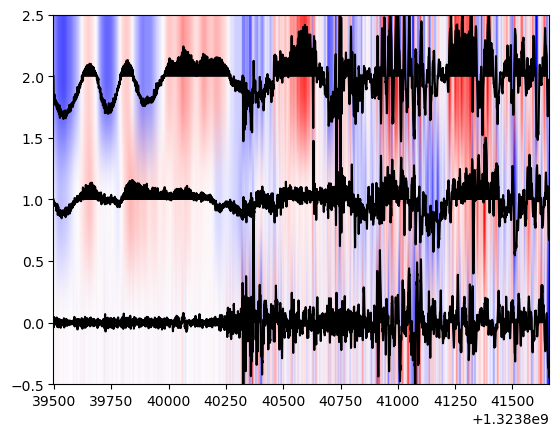

In [6]:
# we need this MsPASS module to make plotting a Seismogram easier
from mspasspy.graphics import SeismicPlotter
plotter = SeismicPlotter(normalize=True)   # instantiates an instance of a SeismicPlotter object
doc = db.wf_Seismogram.find_one()
d = db.read_data(doc,collection="wf_Seismogram")
plotter.plot(d)
plt.show()


This set of print statements are mostly copied from the comparable box above for `TimeSeries` with a couple changes for differences in "concept". 

In [7]:
# copied from above - attribute names are the same 
print("Number of points in the data vector is d.npts=",d.npts)
print("The sample interval is d.dt=",d.dt)
print("The data start time in epoch seconds is d.t0=",d.t0)
print("The UTC time of d.t0=",UTCDateTime(d.t0))
print("The special variable d.tref={} defines the time standard as UTC".format(d.tref))
# these is the key difference for a Seismogram
print("The type of d.data=",type(d.data))
print("The tranformation matrix for this object is d.tmatrix=",d.tmatrix)

Number of points in the data vector is d.npts= 86602
The sample interval is d.dt= 0.025
The data start time in epoch seconds is d.t0= 1323839497.0
The UTC time of d.t0= 2011-12-14T05:11:37.000000Z
The special variable d.tref=TimeReferenceType.UTC defines the time standard as UTC
The type of d.data= <class 'mspasspy.ccore.utility.dmatrix'>
The tranformation matrix for this object is d.tmatrix= [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 5.23596383e-03  9.99986292e-01  2.64845403e-14]
 [ 9.99986292e-01 -5.23596383e-03  2.64845403e-14]]


A few things to note:
1.  The *data* attribute is now a matrix instead of a vector.   An "implementation detail" is that the thing storing the data is a lightweight C++ class called a "dmatrix" and the "shape" of the matrix is 3Xnpts.
2.  The transformation matrix for this datum is NOT cardinal.   The reason is this is TA data where the sensor orientation was measured to high precision and the processing you did to create this thing defined this matrix correctly to reflect a small rotation of the horizontal components.  

### Ensembles
A final important core data type of MsPASS is the concept of what we call an *Ensemble*.   A synonymn for ensemble that some students may recognize from seismic reflection processing is a *gather*.   That is, the key concept is that an *Enemble/gather* is a set of objects that have some generic relationship.   e.g. in seismic reflection processing common jargon terms are:  "shot gather" for data one active source, "CMP gather" for data assembled in midpoint coordinates, "common receiver gather" for a collection of data from a common receiver position.  The point is an ensemble/gather is a subset of a larger data set defined by some subset selection.  If you are familiar with database concepts, "subset" is a key function of any database.  Hence, a key thing to realize is that in MsPASS creating an ensemble usually involves a database query to define the subset to be bundled together into and ensemble object.   The following code block illustrates a type example for event processing (appropriate of this tutorial since the data are looking at are teleseismic events):

The number of TimeSeries data in this data set with source_id= 687b704380969e8354f86c4c  is  1311


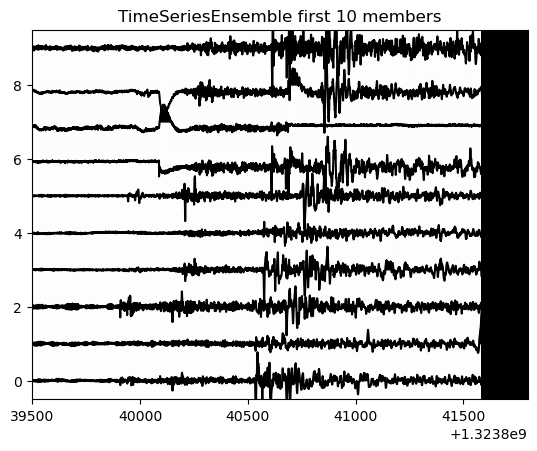

In [8]:
# grab the first source record for this demo - not a generic alorithm
doc = db.source.find_one()
# extract the source_id that is a unique key we can use for a query
srcid = doc["_id"]
query = {"source_id" : srcid}
n=db.wf_TimeSeries.count_documents(query)
print("The number of TimeSeries data in this data set with source_id=",srcid," is ", n)
cursor = db.wf_TimeSeries.find(query).limit(10)     # limit to first 10 to make plot legible in the notebook
e = db.read_data(cursor,collection="wf_TimeSeries")
# this sets the plot title
plotter.title="TimeSeriesEnsemble first 10 members"
plotter.plot(e)
plt.show()

We will look at some of the database constructs used in that code block later, but for now the key thing to recognize is that ensemble is just a collection of several "atomic objects (in MsPASS that means `TimeSeries` or `Seismogram` objects).   A few key details are best seen with some print statements comparable to what we did for atomic data above: 

In [9]:
print("The type of the ensemble we created is ",type(e))
print("The atomic components are stored in the member attribute which for this case has type=",type(e.member))

The type of the ensemble we created is  <class 'mspasspy.ccore.seismic.TimeSeriesEnsemble'>
The atomic components are stored in the member attribute which for this case has type= <class 'mspasspy.ccore.seismic.TimeSeriesVector'>


To get the size of an ensemble used the python len function:

In [10]:
print("The size of this ensemble=",len(e.member))

The size of this ensemble= 10


The member attribute is "iterable" and can be subscripted.  e.g. here we extract and plot member 3:

The type of d= <class 'mspasspy.ccore.seismic.TimeSeries'>


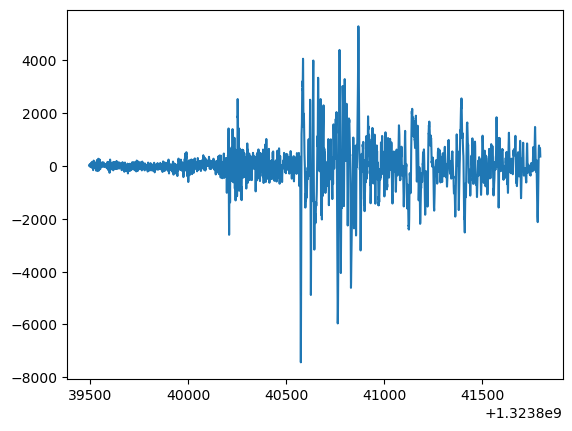

In [11]:
d = e.member[3]
print("The type of d=",type(d))
plt.plot(d.time_axis(),d.data)
plt.show()

Note a `SeismogramEnemble` has exactly the same attribute names as a `TimeSeriesEnsemble` with only one significant difference:  the member attribute is an iterable container with `Seismogram` objects inside instead of `TimeSeries` objects. 

### Metadata
All seismic data objects in MsPASS (i.e. the four things just covered above) in OOP jargon are "subclasses of Metadata".   That means that each data object "is a Metadata container" as well as a seismic data container.  From the precourse work I can assume you all are familiar with python dictionaries.  The MsPASS `Metadata` container is mostly but not exactly synonmyous with a python dictionary.   The reasons are technical and irrelevant.  The key thing to realize is all seismic data objects act like python dictionaries.  This small code block that reloads the `TimeSeries` object we started with illustrates the key ideas:

In [12]:
from mspasspy.util.seismic import print_metadata
doc = db.wf_TimeSeries.find_one()
print("////////////////////////////////////////////////////////////////")
print("This is the python dictionary that will be used to construct d")
print("////////////////////////////////////////////////////////////////")
print_metadata(doc)
d = db.read_data(doc)
print("////////////////////////////////////////////////////////////////")
print("This is the Metadata container content of d after it was constructed")
print("////////////////////////////////////////////////////////////////")
print_metadata(d)


////////////////////////////////////////////////////////////////
This is the python dictionary that will be used to construct d
////////////////////////////////////////////////////////////////
{
  "_id": {
    "$oid": "687b70e780969e8354f87741"
  },
  "rayp_P": 262.2173338238967,
  "starttime": 1302187455.4,
  "delta": 0.025,
  "sampling_rate": 40.0,
  "utc_convertible": true,
  "chan": "BHE",
  "calib": 1.0,
  "net": "TA",
  "format": "binary",
  "seaz": 316.839393933482,
  "source_id": {
    "$oid": "687b704380969e8354f86c58"
  },
  "Ptime": 1302187555.3899658,
  "dfile": "Event_7.msd",
  "nbytes": 192008,
  "dir": "/home/jovyan/mspass_tutorial/Earthscope2025/wf_TimeSeries",
  "foff": 0,
  "npts": 24001,
  "epicentral_distance": 93.82544019746925,
  "sta": "034A",
  "site_id": {
    "$oid": "687b70b780969e8354f86c61"
  },
  "time_standard": "UTC",
  "channel_id": {
    "$oid": "687b70b780969e8354f86c61"
  },
  "rayp_S": 499.0577889447236,
  "esaz": 50.82447823076846,
  "storage_mode"

The key point is except for the order the output of the json display of the python dictionary (doc) and the content of the Metdata container of d are identical.

This illustrates a few features of Metadata that are typical python dictionary constructs:

In [13]:
print("Station code=",d["sta"])
print("The number of attributes stored in the Metadata contaienr of d=",len(d))
for k in d.keys():
    print("the value associated with key=",k," is of type ",type(d[k]))

Station code= 034A
The number of attributes stored in the Metadata contaienr of d= 29
the value associated with key= nbytes  is of type  <class 'int'>
the value associated with key= delta  is of type  <class 'float'>
the value associated with key= channel_id  is of type  <class 'bson.objectid.ObjectId'>
the value associated with key= dir  is of type  <class 'str'>
the value associated with key= starttime  is of type  <class 'float'>
the value associated with key= time_standard  is of type  <class 'str'>
the value associated with key= sta  is of type  <class 'str'>
the value associated with key= dfile  is of type  <class 'str'>
the value associated with key= net  is of type  <class 'str'>
the value associated with key= sampling_rate  is of type  <class 'float'>
the value associated with key= utc_convertible  is of type  <class 'bool'>
the value associated with key= storage_mode  is of type  <class 'str'>
the value associated with key= is_abortion  is of type  <class 'bool'>
the value as

### Break and First Assignment
At this point we will take a short break.   If you have time and care to do so you may start on the first quiz for this session in Moodle on the topics I covered above.  That quiz is also homework so you may want to wait until later to complete it.   

When we reconvene there will be a short lecture on MongoDB that builds on the precourse lecture on the general database concepts. 

## MongoDB Fundamentals
*Learning goals of this section*:

- Students will learn the following generic concepts of MongoDB
  * What a document database is
  * Create Read Update and Delete (CRUD) database concepts
  * The pymongo query language 
  * Why an index is essential for performance in a document database
- Students will learn the following concepts about how MsPASS utilizes MongoDB
  * Waveform collections and contents
  * The MsPASS abstraction of data object construction from a MongoDB document
    - File-based constructors
    - URL-based constructors (important for session 3)
    - Handling formats
  * The “source” collection for managing event data
  * The “channel” and “site” collections for managing receiver data
  * Normalization – what it is, why it is necessary, how to define the operations, and how to use it in waveform processing

### The Database Object
We have been using an instance of the MsPASS database handle.  In this notebook the working instance has the symbolic name *db*.  Consider the following output noting it only partially captures the complexity of *db*:

In [14]:
print(type(db))
dir(db)

<class 'mspasspy.db.database.Database'>


['_BaseObject__codec_options',
 '_BaseObject__read_concern',
 '_BaseObject__read_preference',
 '_BaseObject__write_concern',
 '_Database__client',
 '_Database__name',
 '__annotations__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_atomic_save_all_documents',
 '_channel_is_not_in_db',
 '_check_attribute_types',
 '_check_links',
 '_check_mismatch_key',
 '_check_required',
 '_check_undefined_keys',
 '_check_xref_key',
 '_command',
 '_construct_atomic_object',
 '_construct_ensemble',
 '_conv

The main lesson you should take from the above is that an instance of the class type `mspasspy.db.database.Database` is complex because it bundles together a lot of functionality.  That functionality, however, is central to using MsPASS because a handle like db is central to data management with the package.   

### Collections and Documents
As I noted in the lecture MongoDB is a "document" database and it groups "documents" into collections.   For students familiar with relational databases I reiterate here that a "collection" in MongoDB plays the same role as a "relation" (table) in a relational db and a "document" plays the same role as a "tuple" (row of a table).  

This code box will show us the collections that exist in the database we have been working with:

In [15]:
cursor = db.list_collections()
for doc in cursor:
    print(doc['name'])

abortions
channel
site
cemetery
wf_TimeSeries
source
wf_Seismogram
history_object
wf_miniseed
elog


The key thing to understand about collections at this point is they are used to organize information that has a common structure.   Each collection is made up of one or more "documents" that contain data with a (mostly) common structure.   We saw examples of "documents stored in wf_TimeSeries earlier.   Here, for example, is a similar box showing the first document in the wf_TimeSeries collection:

In [16]:
doc=db.wf_TimeSeries.find_one()
print("The type of the thing returned by find_one  (symbol doc) = ",type(doc))
print("Content of this document")
print_metadata(doc)

The type of the thing returned by find_one  (symbol doc) =  <class 'dict'>
Content of this document
{
  "_id": {
    "$oid": "687b70e780969e8354f87741"
  },
  "rayp_P": 262.2173338238967,
  "starttime": 1302187455.4,
  "delta": 0.025,
  "sampling_rate": 40.0,
  "utc_convertible": true,
  "chan": "BHE",
  "calib": 1.0,
  "net": "TA",
  "format": "binary",
  "seaz": 316.839393933482,
  "source_id": {
    "$oid": "687b704380969e8354f86c58"
  },
  "Ptime": 1302187555.3899658,
  "dfile": "Event_7.msd",
  "nbytes": 192008,
  "dir": "/home/jovyan/mspass_tutorial/Earthscope2025/wf_TimeSeries",
  "foff": 0,
  "npts": 24001,
  "epicentral_distance": 93.82544019746925,
  "sta": "034A",
  "site_id": {
    "$oid": "687b70b780969e8354f86c61"
  },
  "time_standard": "UTC",
  "channel_id": {
    "$oid": "687b70b780969e8354f86c61"
  },
  "rayp_S": 499.0577889447236,
  "esaz": 50.82447823076846,
  "storage_mode": "file",
  "endtime": 1302188055.4,
  "data_tag": "serial_preprocessed"
}


Points to note:
- a "document" is translated by pymongo (the package we are using to communicate with the MongoDB server) into a python dictionary
- A document is defined by key-value pairs.  In MsPSS the keys are assumed to have a common meaning inside that collection and the values for each key are assumed to be the same same type.  Note that is not something MongoDB enforces but should normally be done to avoid mysterious errors when handling millions of documents.
- The print_metadata function we used translates the dictionary into "json-format" text output

What is not shown by that example is that unlike a table, key-value pairs can be missing from a document and it makes no difference to the MongoDB server.   

Finally, on this point here is a document from a completely different collection we call "site* that is used largely to hold station location information.  I show two documents to illustrate the common set of keys that make the collection useful.

In [17]:
cursor=db.site.find({}).limit(2)
for doc in cursor:
    print_metadata(doc)

{
  "_id": {
    "$oid": "687b70b780969e8354f86c61"
  },
  "loc": "",
  "net": "TA",
  "sta": "034A",
  "lat": 27.064699,
  "lon": -98.683296,
  "coords": [
    -98.683296,
    27.064699
  ],
  "location": {
    "type": "Point",
    "coordinates": [
      -98.683296,
      27.064699
    ]
  },
  "elev": 0.155,
  "edepth": 0.0,
  "starttime": 1262908800.0,
  "endtime": 1321574399.0,
  "site_id": {
    "$oid": "687b70b780969e8354f86c61"
  }
}
{
  "_id": {
    "$oid": "687b70b780969e8354f86c64"
  },
  "loc": "",
  "net": "TA",
  "sta": "035A",
  "lat": 26.937901,
  "lon": -98.102303,
  "coords": [
    -98.102303,
    26.937901
  ],
  "location": {
    "type": "Point",
    "coordinates": [
      -98.102303,
      26.937901
    ]
  },
  "elev": 0.029,
  "edepth": 0.0,
  "starttime": 1263254400.0,
  "endtime": 1321315199.0,
  "site_id": {
    "$oid": "687b70b780969e8354f86c64"
  }
}


### CRUD
A near universal mnemonic found in books on database theory and online tutorials is the acronymn CRUD.  CRUD is short for Create-Read-Update-Delete.  It is used to as a mnenomic to remember those four primry functions any operational database must be capable of doing.   In this class we will focus mainly on  the C (Create==writers) and R (readers).   Reading and writing are pretty much essential for all MsPASS workflows.  Updates and deletes, in contrast, are rarely needed and, in fact, are usually ill advised and best done not within a larger workflow but as a sidebar to fix some problem.  A notable exception is [normalization](https://www.mspass.org/user_manual/normalization.html) we will discuss later.  In any case, to reduce information overload this class will focus on read and write operations.  When you use MsPASS if you understand the syntax for the C and R functions of MongoDB the forms for the U and D functions are completely logical.   You can also consult the sections in the [User Manual on CRUD operations](http://www.mspass.org/user_manual/CRUD_operations.html) and the section titled ["Using MongoDB with MsPASS"](http://www.mspass.org/user_manual/mongodb_and_mspass.html).

#### Create
The first letter in the CRUD acronynm is "Create".  For all applications some form of "create" is an essential first step to put some kind of data into your database. The main purpose of the workflow you ran before the start of this class was to drive a string of create operations.   Let's collectively look at the notebook "PrecourseProcessing.ipynb".   Double click that notebook with the file browser in jupyter lab.  We will look at the context there of the following sequence of "Create" steps in that notebook (you can search the highlighted keyword if you have trouble finding any of these):

1.  The *save_catalog* is a method of the MsPASS extension of `Database`.  It takes apart an obspy [Catalog](https://docs.obspy.org/packages/autogen/obspy.core.event.Catalog.html) object, converts it into a python dictionary, and saves one document in the "source" collection (see list above) for each event stored in the "Catalog".  That "Catalog" object is created by running an obspy web service method called [get_events](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_events.html).  
2.  The *index_miniseed_file" method is another MsPASS extension.  It reads through a miniseed file to build an index of the file.   We'll look at what that index looks like momentarily when we consider the "R" of CRUD below.
3.  The *save_inventory* method is another extension.  It performs a function similar to *save_catalog* in that it builds on an obspy capability.  That is, the workflow uses the obspy web services function, [get_stations](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_stations.html), to fetch requested station Metadata from FDSN data centers.  The retrieval stores that data in memory as an obspy [inventory](https://docs.obspy.org/packages/autogen/obspy.core.inventory.inventory.Inventory.html) object.  As the name *save_inventory* implies it takes apart the Inventory object and reorganizes the data into two MongoDB collections called "channel" and "site". Those two are the MsPASS collections used to store station Metadata.
4.  Box 12 does some low-level processing.  It does an R of CRUD operation using the *read_data* method we used above, applies several processing functions (we will discuss them later), and then calls the *save_data* method of the MsPASS `Database` object (*db* symbol).  That saves processed `TimeSeries` objects (the content of the data stored with the symbol *d*) as files with the Metadata content of each datum stored in a collection called *wf_TimeSeries*.  That box is a typical serial processing loop in MsPASS over "atomic" data.  
5.  The algorithm in Box 13 takes the content of the entire *wf_TimeSeries* collection and converts all possible combinations to `Seismogram` objects.   It does that by running the [bundle_seed_data](https://www.mspass.org/python_api/mspasspy.algorithms.html#module-mspasspy.algorithms.bundle) function.   The algorithm is another serial loop processing sequence but differs from the previous by looping over ensemble objects instead of atomic data.   The loop again terminates with a call to the `Database.save_data` method, but in this case `save_data` is handling `SeismogramEnsemble` objects instead of `TimeSeries` objects.

A summary of what the above produced is the report produced by this small code segment:

In [18]:
for collection in ["source","wf_miniseed","channel","site","wf_TimeSeries","wf_Seismogram"]:
    n = db[collection].count_documents({})
    print("The {} collection contains {} documents".format(collection,n))

The source collection contains 20 documents
The wf_miniseed collection contains 26247 documents
The channel collection contains 2784 documents
The site collection contains 857 documents
The wf_TimeSeries collection contains 25314 documents
The wf_Seismogram collection contains 8395 documents


With those counts and the processing that workflow did you should not be surprised that notebook took several minutes to run.  It is also important to note that ALL of these C operations used in that workflow use MsPASS extensions.   Online tutorials you may read on MongoDB will not discuss any of those for C operation, but instead will show examples for the low level `insert_one` and `insert_many` described __[here in the pymongo documentation](https://pymongo.readthedocs.io/en/stable/api/pymongo/collection.html)__.  Those two methods are used to insert plain documents (i.e. data stored in a python dictionary) into a MongoDB collection.   If you examine the python code of the MsPASS extensions you will see that all of them have calls within them to one of the pymongo insert methods.  You should think of the MsPASS extensions as way to automate saving MsPASS data objects. The readers we discuss below do the inverse constructing an object from a MongoDB document.  

There is an important detail in running the `save_data` method we need to emphasize before moving to "R" of CRUD.

##### Storage Mode Options
The [save_data](http://www.mspass.org/python_api/mspasspy.db.html#mspasspy.db.database.Database.save_data) method of `Database` has an argument called "storage_mode".   It determines how the sample data are saved.   The options are string keywords that must be one of the following:
1.  "gridfs" (the default) saves the sample data internally in the MongoDB data area.  In this mode the sample data are stored in file-like objects managed by MongoDB and with MongoDB generated documents needed to define them in the two collections called "fs.files" and "fs.chunks".  Gridfs is convenient storage because it is easier to manage as an integrated and bombproof storage area managed completely by MongoDB.   The dark side is we know from experience writing data to gridfs can cause an io bottleneck since the more voluminous sample data have to pass through the same io channel as the Metadata write operations (the actual calls to `insert` to "wf_TimeSeries` or `wf_Seismogram`.  Furthermore, it puts the voluminoous sample data on the same file system where the database is stored.  That is universally a bad idea for large data sets.
2.  "files", as the name suggests, writes data to conventional computer files.   When using the option `storage_mode="file"` in a call to `save_data` by definition the writer has to know what file it should open and use to save the requested data.  The best way to do that is to set an explicit value for `dir` and/or `dfile` in the line where you call `save_data`.  If the arguments are not defined, `save_data` attempts to extract values from each atomic datum's Metadata container using the same keywords. (i.e. attempts to retrieve two string values with the keys "dir" and "dfile".  If that fails, it falls to the last resort;  "dir" will be set as to the run directory and "dfile" will be defined by a unique, random string. In all cases the file name is then generated by using the stock python `join` method of the `os.path`.   That is, the file name is generated as `fname=os.path.join(dir,dfile)`.  `save_data` then attempts to open the file.  If successful it seeks to the end of the file, posts the byte offset as the "foff" attribute, and writes the sample data.   The default is a raw binary dump, but as described in the User Manual and docstring for [save_data](http://www.mspass.org/python_api/mspasspy.db.html#mspasspy.db.database.Database.save_data) the output can be written in any format supported by obspy's writer (subject to major issues of rigid namespace requirements for many formats.)  All should recognize that using files requires some thought beforehand about how the files should be named and organized.   The model used is heavily project dependent and outside the scope of this course.

There is one more detail about writing data that is an important performance issue.  That is, when working with atomic data MsPASS will always open a file, write data, and then close the file.  All three operations take nontrivial amounts of time to complete.  The excessive open-close commands are intrinsic bottlenecks on any system.   The fastest write model is possible with ensembles written in the default binary mode as done here in box 13.   In that mode, a file is opened only once for each ensemble and the data are dumped sequentially to the same file using a the low-level C fwrite function.

#### Read
The single biggest advantage of using a database for managing a large seismic data set is the query capability that are central to the R of CRUD.   If all seismic data used the same data that was always in the same order a database would not be necessary.  There is, however, a wide variation of what a given research project needs for input data and how that data needs to be grouped and processed.  Hence, selection of data and grouping them into logical chunks is always required.  Databases are a scalable way to do that and MsPASS is designed to perform those operations as simply as possible. 

You should first realize that there are two fundamentally different types of read operations you will need to use to process your data with MsPASS:
1.  All waveform processing should be driven by documents retrieved from MongoDB.  In MsPASS the model is that there is a one-to-one mapping between documents stored in one of the "wf" collections (i.e. the "wf_miniseed", "wf_TimeSeries", or "wf_Seismogram" collections we discussed above).  Unless something goes wrong (always possible - something called an "abortion" during read) your workflow should assume each document can be used to construct one atomic data object (i.e. `TimeSeries` or `Seismogram`). The standard tool to do that is the __[Database.read_data](https://www.mspass.org/python_api/mspasspy.db.html#mspasspy.db.database.Database.read_data)__ method we used several times above and just discussed with the precourse workflow disucssion.
2.  The core pymongo read methods are two "collection" methods called:  `find` and `find_one` __[discussed here](https://www.mongodb.com/docs/languages/python/pymongo-driver/current/crud/query/find/)__ and in numerous online sources.

It is important to understand that the MsPASS `read_data` method is a higher level operator that expects to use the output of a `find` or `find_one` method as it's input.   In particular, if you refer back to examples earlier you will see:
- The pymongo `find_one` method returns a document/dictionary.   When `read_data` detects a document as arg0 it assumes that document is a template to create an atomic seismic data object.  It then calls the constructor for that object and creates one.  Here is an example that is similar to one we did earlier but using wf_miniseed:

In [19]:
doc = db.wf_miniseed.find_one()
d = db.read_data(doc,collection="wf_miniseed")
print("The data type of d is ",type(d))

The data type of d is  <class 'mspasspy.ccore.seismic.TimeSeries'>


- The pymongo `find` operation returns a special concept called a "command cursor".  When `read_data detects a command cursor is assumes it has the output of a find operatoin applied to a wf collection.  It will then attempt to construct an ensemble object from that "cursor".  Here is a variant of such a construct of one we used earlier that illustrates what I meand:

In [20]:
doc = db.source.find_one()
# extract the source_id that is a unique key we can use for a query
srcid = doc["_id"]
query = {"source_id" : srcid}
n=db.wf_Seismogram.count_documents(query)
print("The number of Seismogram data in this data set with source_id=",srcid," is ", n)
cursor = db.wf_Seismogram.find(query)
e = db.read_data(cursor,collection="wf_Seismogram")
print("The data type of e returned by read_data is ",type(e))
print("The number of members in e=",len(e.member))

The number of Seismogram data in this data set with source_id= 687b704380969e8354f86c4c  is  437
The data type of e returned by read_data is  <class 'mspasspy.ccore.seismic.SeismogramEnsemble'>
The number of members in e= 437


Every database system I know of implements some version of the concept encapsulated by the pymongo class called a [CommandCursor](https://pymongo.readthedocs.io/en/stable/api/pymongo/command_cursor.html).   A "cursor" is a standard return from any query like operation in any database system.  A MongoDB `CommandCursor` is technically a __[forward iterator](https://www.boost.org/sgi/stl/ForwardIterator.html)__.   That means it acts like a list that can only be traversed "forward".  In python that means it is done as a `for x in y:`  construct.  For instance, the cursor in the above could be tranversed with this construct:
```
   for doc in cursor:
      d = db.read_data(doc,collection="wf_Seismogram")
```
to handle the ensemble members at the atomic level rather than grouping them into an ensmeble. 

A command cursor, however, is not at all the same thing as a python list. It just acts like one.  It is a handle that interacts with the database to sequentially return documents.  It is fundamentall different, however, in two ways:
1. The content of what it references often do not fit in memory.  It should be thought of as like a file handle being read sequentially. The client-server pair manage the grungy work of trying to keep the memory buffer full and assuring the client does no have to wait for data to arrive.  The important thing that means is that when reading a very large amount of data (e.g. processing millions of TimeSeries objects driven by wf_miniseed records) sequential reads with a cursor almost never have to wait for data. That is in contrast to atomic queries where a there is a large lag between the time a client issues a query and the server can response with a single document.
2. A cursor is not subscriptable.  That is a consequence of the definition as  forward iterator.  It can only be traversed sequentially like reading data sequentially from a file.  

#### Mongo Query Language (MQL)
The standard language for interaction with relational database system is a language called "Structured Query Language" (SQL).   MongoDB uses a completely different language.  MongoDB suffers, in my opinion, from a lack of useful online resources that provide any kind of overview.  MongoDB is utilized enough that there are textbooks on the package.  If the resources I point you to here are not sufficient you might consult your local campus library for books on MongoDB as a learning aid.   In previous versions of this class I spent a lot of time on MQL.  However, MQL is like a language best learned by being immersed in it.   Hence, in this version of this class I will only highlight a few things that are needed to get you started. As you use MsPASS you will quickly learn the language as it is actually simpler than SQL. 

A good referencde for this section is the MsPASS User Manual section titled ["Using MongoDB with MsPASS"](http://www.mspass.org/user_manual/mongodb_and_mspass.html).  A starting point is synax rules defining MQL.  The manual page above has this definition for MQL in pymongo:

1.  All queries use a python dictionary to contain the instructions.
2.  The key of a dictionary used for a query normally refers to an attribute
    in documents of the collection being queried.  There is an exception to this rule
    for the logical OR and logical AND operators (discussed below).
3.  The "value" of each key-value pair is normally itself a python
    dictionary.   The contents of the dictionary define a simple
    language (Mongo Query Language) that resolves True for a match
    and False if there is no match.  The key point is the overall
    expression the query dictionary has to resolve to a boolean condition.
4.  The keys of the dict containers that are on the value side of
    a query dict are normally operators.  Operators are defined with
    strings that begin with the "\$" symbol.
5.  Simple queries are a single key-value pair with the value either
    a constant or a dictionary with a single operator key.  e.g.
    to a test for the "sta" attribute being the constant "AAK" the
    query could be either `{"sta" : "AAK"}` or `{"sta" : {"$eq" : "AAK"}}`.
    The form with constant value only works for "$eq".
6.  Compound queries (e.g. time interval expressions) have a value
    with multiple operator keys.
7.  There is an implied logical AND operation
    between multiple key operations.  An OR must be specified differently
    (see below).

That set of rule is a case in point of why we are only going to do some simple example here.   Those are like foreign language grammar rules. Use them for generic guidance and learn the details by apply examples in sources give here and online. 

For reference the examples below are all derived from __[this notebook of the 2024 version of this course](https://github.com/mspass-team/mspass_tutorial/blob/master/Earthscope2024/Session2.ipynb)__.   You can use that as a reference to understand each of these examples.  There are more detailed explanations of each example there.    

First, a unique match query:

In [21]:
# find all documents in site for station 035A
query = {"sta" : "034A"}
cursor = db.site.find(query)
for doc in cursor:
    print_metadata(doc)

{
  "_id": {
    "$oid": "687b70b780969e8354f86c61"
  },
  "loc": "",
  "net": "TA",
  "sta": "034A",
  "lat": 27.064699,
  "lon": -98.683296,
  "coords": [
    -98.683296,
    27.064699
  ],
  "location": {
    "type": "Point",
    "coordinates": [
      -98.683296,
      27.064699
    ]
  },
  "elev": 0.155,
  "edepth": 0.0,
  "starttime": 1262908800.0,
  "endtime": 1321574399.0,
  "site_id": {
    "$oid": "687b70b780969e8354f86c61"
  }
}


This example uses a range query in combination with what MongoDB calls a "projection".  A projection is equivalent to "SELECT" in SQL. It also illustrates use of pandas DataFrame objects that are useful containers or some types of database operations.  

In [22]:
query={
    'lat' : {'$gte' : 30.0,'$lte' : 35.0},
    'lon' : {'$gte' : -110.0, '$lte' : -100},
}
projection={
   'net':1,
    'sta':1,
    'chan':1,
    'lat':1,
    'lon':1,
    'elev':1,
    '_id':0, 
}

cursor=db.site.find(query,projection)
doclist=[]
for doc in cursor:
    doclist.append(doc)
import pandas as pd
df = pd.DataFrame.from_dict(doclist)
print(df)

   net   sta        lat         lon   elev
0   TA  121A  32.532398 -107.785103  1.652
1   TA  123A  32.634899 -106.262199  1.206
2   TA  124A  32.700100 -105.454399  2.078
3   TA  125A  32.658798 -104.657303  1.212
4   TA  126A  32.646198 -104.020401  1.032
..  ..   ...        ...         ...    ...
71  TA  Z27A  33.314999 -103.214500  1.197
72  TA  Z28A  33.288399 -102.386597  1.045
73  TA  Z29A  33.259499 -101.706200  0.938
74  TA  Z30A  33.286098 -101.128197  0.729
75  TA  Z31A  33.318298 -100.143501  0.547

[76 rows x 5 columns]


In [23]:
query['lat']

{'$gte': 30.0, '$lte': 35.0}

Finally, an example that combines sorting with find.

In [24]:
projection = {
    "_id":0,
    "net":1,
    "sta":1,
    "chan":1,
    "starttime":1,
    "endtime":1,
}
sort_clause = [
    ("net",1),
    ("sta",1),
    ("chan",1),
    ("starttime",1),
  ]
# obscure syntax to find all documents with station name starting with Z
query={
    'sta' : {'$regex' : '^Z.*'},
}
cursor=db.channel.find(query,projection).sort(sort_clause)
doclist=[]
for doc in cursor:
    doclist.append(doc)
df = pd.DataFrame.from_dict(doclist)
print(df)

   net   sta     starttime       endtime chan
0   TA  Z14A  1.173139e+09  1.275059e+09  BHE
1   TA  Z14A  1.173139e+09  1.275059e+09  BHN
2   TA  Z14A  1.173139e+09  1.275059e+09  BHZ
3   TA  Z22A  1.207867e+09  1.269121e+09  BHE
4   TA  Z22A  1.207867e+09  1.269121e+09  BHN
..  ..   ...           ...           ...  ...
91  TA  Z49A  1.324253e+09  1.375797e+09  BHN
92  TA  Z49A  1.324253e+09  1.375797e+09  BHZ
93  TA  Z50A  1.324512e+09  1.358813e+09  BHE
94  TA  Z50A  1.324512e+09  1.358813e+09  BHN
95  TA  Z50A  1.324512e+09  1.358813e+09  BHZ

[96 rows x 5 columns]


#### Indexing
A find/subset/select (different words for the same concept used in different dbms software) operation in any database is very very slow if the selection criteria is some arbitrary attribute stored in each document.   The reason is that without an index a find operation has to do a linear search of the entire collection to fufill the request.   An index on one or more keys produces a fast index to speed up that process.   

To demonstrate how much of a difference we query the *channel* collection for a station "034A" with an exact match query similar to above but this time we time how it takes to load the data a command cursor references:

In [25]:
import time
query = {"sta" : "034A"}
t0 = time.time()
cursor = db.channel.find(query)
doclist=[]
for doc in cursor:
    doclist.append(doc)
t=time.time()
print("Elapsed time to read ",len(doclist)," documents=",t-t0)

Elapsed time to read  3  documents= 0.003477811813354492


Now let's build a common index for channel for the seed channel codes which in MsPASS are called *net, sta*, and *chan*. 

In [26]:
from pymongo import ASCENDING
index_response = db.channel.create_index([
    ("net", ASCENDING),
    ("sta", ASCENDING),
    ("chan",ASCENDING),  
])
print(index_response)

net_1_sta_1_chan_1


This is a duplicate of the box above, but channel now has an index that refernces sta. 

In [27]:
import time
query = {"sta" : "034A"}
t0 = time.time()
cursor = db.channel.find(query)
doclist=[]
for doc in cursor:
    doclist.append(doc)
t=time.time()
print("Elapsed time to read ",len(doclist)," documents=",t-t0)

Elapsed time to read  3  documents= 0.003111124038696289


The times are not hugely different in this case because the channel collection is relatively small.   In contrast I've seen examples for a collection with millions of documents where the times differ by 100 or more.  From the introduction of indexes above you should be able to figure why an index becomes progressively critical as the size of a collection increases.  The following is a more typical application for waveform data to speed access to common source gathers:

In [28]:
db.wf_Seismogram.create_index("source_id")   # note simpler syntax for a single key index
db.wf_TimeSeries.create_index("source_id")

'source_id_1'

### Waveform read details
We will finish this section to consider some more details of the `Database.read_data` method.   To appreciate this section your need a sound understanding of two things we covered above:
1.  The concepts of what defines a MsPASS, atomic, seismic data object - `TimeSeries` or `Seismogram`.
2.  The idea of what a "document" stored in MongoDB is and how to fetch one or more of them.

Because `read_data` is such a central player in MsPASS workflows it will help your understanding to know some details about the algorithm inside that method.  I will limit this discusssion to how `read_data` works for atomic reads.  You can and should think of normal ensemble read operations as a loop over a command cursor with the method calling itself for each document the command cursor returns in a `foreach doc in cursor:` loop.

Atomic reads are driven by a document passed as arg0 to the method.  Let's look at a wf_miniseed example and dig into the contents a bit this time:

In [29]:
doc = db.wf_TimeSeries.find_one()
print_metadata(doc)

{
  "_id": {
    "$oid": "687b70e780969e8354f87741"
  },
  "rayp_P": 262.2173338238967,
  "starttime": 1302187455.4,
  "delta": 0.025,
  "sampling_rate": 40.0,
  "utc_convertible": true,
  "chan": "BHE",
  "calib": 1.0,
  "net": "TA",
  "format": "binary",
  "seaz": 316.839393933482,
  "source_id": {
    "$oid": "687b704380969e8354f86c58"
  },
  "Ptime": 1302187555.3899658,
  "dfile": "Event_7.msd",
  "nbytes": 192008,
  "dir": "/home/jovyan/mspass_tutorial/Earthscope2025/wf_TimeSeries",
  "foff": 0,
  "npts": 24001,
  "epicentral_distance": 93.82544019746925,
  "sta": "034A",
  "site_id": {
    "$oid": "687b70b780969e8354f86c61"
  },
  "time_standard": "UTC",
  "channel_id": {
    "$oid": "687b70b780969e8354f86c61"
  },
  "rayp_S": 499.0577889447236,
  "esaz": 50.82447823076846,
  "storage_mode": "file",
  "endtime": 1302188055.4,
  "data_tag": "serial_preprocessed"
}


The first thing the reader does is call a constructor for a `TimeSeries` object that loads the entire document into the object's `Metadata` container and creates the `data` vector of size defined by the attribute definition `"npts" : 768000"`.  A key point here is that the wf_TimeSeries document serves as only a template to create a partially completed `TimeSeries` object.  To build a valid object the sample data have to then be loaded.

A critical attribute for the reader is this one:  `"storage_mode": "file"`.   Other valid values are "gridfs" and "url".   "gridfs" uses an internal storage system managed by MongoDB.   It is the default and has the advantage of being easy to use.  It is not recommended for large data sets, however, for a variety of reason discussed in detail in __[this section of the MsPASS User Manual](https://www.mspass.org/user_manual/io.html)__.  "url" is used to abstract the process of reading form a network connection via web services or, as we will see in the 3rd session of this class, data stored in a cloud service like Amazon Web Services S3 system.  

For this example, file IO demands the following attributes:
1. *dir* and *dfile* define the path to the file to be read.
2. *foff* is the number of bytes to __[seek](https://www.geeksforgeeks.org/python-seek-function/)__ in the file before reading.
3. *format* is an optional attribute defining a data format (e.g. miniseed or SAC).  The default is the same as this example ("binary") which means the reader loads the data with the C *fread* function for speed.   For other formats, the data have to be converted.  
4. *nbytes* defines the number of bytes to be loaded into memory.  With binary data *npts*, the number of data points, is used as *nbytes* can be inferred as 8*npts.
5. When format is anything but "binary" the reader attempts to call an obspy reader for that format passing the *nbytes* buffer to the reader.  Any of the formats defined supported by obspy described __[here](https://docs.obspy.org/packages/autogen/obspy.core.stream.read.html#supported-formats)__ should technically work, but we have limited experience with anything other than miniseed.

It may be informative to compare the document we just examined to it's parent.  You need to recognize the the wf_TimeSeries object related to that document came by saving a partially processed waveform created by cracking a miniseed file.   This small code segments finds that parent and then prints a few key attributes that show the differences:

In [30]:
query = {"net" : doc["net"],
          "sta" : doc["sta"],
          "chan" : doc["chan"],
         "source_id" : doc["source_id"],
        }
# verify that is a unique match
n = db.wf_miniseed.count_documents(query)
print("Number of documents matching query=",n)
# since 1 we can use find_one for simplicity
doc = db.wf_miniseed.find_one(query)
for k in ["format","nbytes","npts","dir","dfile","foff"]:
    print("{} : {}".format(k,doc[k]))
         

Number of documents matching query= 1
format : mseed
nbytes : 86016
npts : 92000
dir : /home/jovyan/mspass_tutorial/Earthscope2025/wf
dfile : Event_7.msd
foff : 0


At your leisure you should study that output and try to understand the differences.  

### Other Standard Collections
It is worth repeating the code box from above that lists all the collections in our demonstration database:

In [31]:
cursor = db.list_collections()
for doc in cursor:
    print(doc['name'])

abortions
channel
site
cemetery
wf_TimeSeries
source
wf_Seismogram
history_object
wf_miniseed
elog


We have used the three "wf" collections extensively in our discussions of waveform data management.  There are two other groups of collections you need to understand:
1.  We have poked into the *source*, *site*, and *channel* collections.  We have looked at them a bit earlier in different contexts.  Briefly note
    - *source* contains information about the source to which a waveform is connected.
    - *site* and *channel* contain station related metadata.   *site* documents are briefer and contain only location information.   *channel* documents have the metadata connected to a particular "channel" of recorded data.   In the SEED world that means a station code defined by the four magic keys "net", "sta", "chan", and "loc" along with a time period for which the metdata are valid.   The documents in this database also contain orientation information and response data created from the obspy *Inventory* object created using web services - we will review that a bit before ending today.
2.  The three collection *elog*, *cemetery*, and *abortions* are related to a feature of MsPASS that is the topic of the next section of this notebook. 

#### kill concept
MsPASS makes extensive use of an approach to data editing that has been used in seismic reflection processing since the earliers processing systems of the 1960s.  The basic idea is that all seismic data objects in MsPASS have a `live` attribute.   When the `live` is set False it tell all MsPASS processing functions to treat that datum as bad.  Processing algorithms do nothing to dead (live==False) data and simply pass them along.   For more on the ideas of why and this is done and how to use this feature for data editing see two sections of the MsPASS User's Manual:   (1) __[Handling Errors](https://www.mspass.org/user_manual/handling_errors.html)__ give a complete concept of trace editing and how it is implemented in MsPASS, and (2) __[Data Editing](https://www.mspass.org/user_manual/data_editing.html)__ describes tools for algorithms that can be used for killing data with certain problems within a workflow.  

For today's topic focused on data management and MongoDB the thing you need to understand is what the three collections called *elog*, *cemetery*, and *abortions* are and what they are used for.  

First, consider *elog*. Let's start with this little code segment to explore what is in our demo database:

In [32]:
n_elog = db.elog.count_documents({})
print("The elog collection of our data base has ",n_elog," documents")
print("This is the first one in that collection")
doc=db.elog.find_one()
print_metadata(doc)

The elog collection of our data base has  1  documents
This is the first one in that collection
{
  "_id": {
    "$oid": "687b725280969e8354f8a830"
  },
  "logdata": [
    {
      "job_id": 0,
      "algorithm": "Database._read_data_from_dfile:  ",
      "badness": "ErrorSeverity.Complaint",
      "error_message": "Inconsistent number of data points (npts)\nDatabase npts=92001 but obspy reader created a vector 86603 points long\nSet to vector size defined by reader.",
      "process_id": 141
    }
  ],
  "data_tag": "serial_preprocessed",
  "wf_TimeSeries_id": {
    "$oid": "687b70660e8592335050a32c"
  }
}


This data set is very clean and as you can see elog is very small.  Tne only error logged is one related to a problem in one of the miniseed files.  It is relatively harmless.   Any time any algorithm posts an error of any kind the message is saved in the database in this *elog* collection with a document like that above.   Queries of elog are necessary if you are having a problem with a lot of data being unexpectedly killed.   

The *cemetery* and *abortions* collections provide a record of two different kinds of "dead data".   *cemetery* contains metadata describing a datum that was killed during processing. There are documents in *abortions* only if there are read problems in constructing one or more data objects.   (An "abortion" is a data object that was never born (constructed successfully)).   Let's explore their contents for this demon database.

In [33]:
n_cemetery=db.cemetery.count_documents({})
print("Number of documents in the cemetery=",n_cemetery)
n_abortions=db.abortions.count_documents({})
print("Number of documents in the abortions collection=",n_abortions)
print("First cemetery document")
doc = db.cemetery.find_one()
print_metadata(doc)
print("First abortions document")
doc=db.abortions.find_one()
print_metadata(doc)

Number of documents in the cemetery= 889
Number of documents in the abortions collection= 210
First cemetery document
{
  "_id": {
    "$oid": "687b70eb80969e8354f877c2"
  },
  "logdata": [
    {
      "job_id": 0,
      "algorithm": "WindowData",
      "badness": "ErrorSeverity.Invalid",
      "error_message": "WindowData(TimeSeries):  Window mismatch\nWindow start time=-100 is sample number -837\nWindow end time=500 is sample number 23163\nParent has 92000 samples\n",
      "process_id": 141
    }
  ],
  "wf_TimeSeries_id": {
    "$oid": "687b70614661afe1a75afe78"
  },
  "tombstone": {
    "_id": {
      "$oid": "687b70614661afe1a75afe78"
    },
    "channel_lat": 32.888901,
    "rayp_P": 461.1618097443309,
    "source_magnitude": 7.3,
    "starttime": 1308885378.0195,
    "delta": 0.025,
    "endtime": 1308887677.9945002,
    "site_lat": 32.888901,
    "channel_vang": 90.0,
    "sampling_rate": 40.0,
    "chan": "BHE",
    "channel_endtime": 1355434199.0,
    "calib": 1.0,
    "net"

Note:
- Both example documents have a "tombstone" attribute.   The "tombstone" is a dump of the Metadata container of the problem datum.
- The *cemetery* example has an embedded "logdata" attribute containing a record similar to elog.  In this example we see the datum was killed because the data had a gap and when the processing windowed the data around P it killed that datum.  The *abortions* example does not have a "logdata" entry.  Sometime they do, but in this case where this came from can be gleaned from errors you can see that were posted when you created this database.  That is, one of the miniseed files has a corrupted section that generates read errors.   The example abortions document can be linked back to that file ("Event_12.msd").  

### Normalization
The final topic for today's discussion of data management is what MongoDB calls "normalization".   For students familiar with relational databases MongoDB "normalization" is conceptually similar to a relational database "join".  A more extensive reference on this topic is the section of the MsPASS User's Manual titled __[Normalization](https://www.mspass.org/user_manual/normalization.html)__.   Before attempting the homework for this session, students should read that section.

Normalization in seismic processing with MsPASS most useful for joining small tables to waveform documents.   We have found that with MongoDB normalization makes sense if the collection to be matched against a waveform collection is small compared to the number of documents in the waveform collection.  Source and receiver Metadata are a case in point.   For a larger wf collection there are many wf documents for each source and wf documents with a common match in a site/channel collection.  

Normalization is implemented in MsPASS in a novel way with a concept we call a "Matcher".  The most useful matchers are those that load an entire collection and have a fast algorithm to match records in a cache to wf documents.  We will look at a full implementation before closing today when we review the processing workflow next.  For now, however, here is an example matcher that is used to match SEED waveform data using net:sta:chan:loc and a time range: 

In [34]:
from mspasspy.db.normalize import MiniseedMatcher
matcher=MiniseedMatcher(db)
print(matcher.attributes_to_load)

['starttime', 'endtime', 'lat', 'lon', 'elev', '_id', 'hang', 'vang']


The print statement shows one attribute of this object called *attributes_to_load*.   It defines what key-value pairs will be loaded from the matchers internal cache that that match that datum.   This short example compares the content of a `TimeSeries` loaded from a doc with and without normalization using the normalizer in *matcher*.

In [35]:
doc=db.wf_TimeSeries.find_one()
d = db.read_data(doc)
print("///////////////////////////////////////////////////////////")
print("Metadata without normalization")
print("///////////////////////////////////////////////////////////")
print_metadata(d)
d = db.read_data(doc,normalize=[matcher])
print("///////////////////////////////////////////////////////////")
print("Metadata with normalization using MiniseedMatcher class")
print("///////////////////////////////////////////////////////////")
print_metadata(d)

///////////////////////////////////////////////////////////
Metadata without normalization
///////////////////////////////////////////////////////////
{
  "nbytes": 192008,
  "delta": 0.025,
  "channel_id": {
    "$oid": "687b70b780969e8354f86c61"
  },
  "dir": "/home/jovyan/mspass_tutorial/Earthscope2025/wf_TimeSeries",
  "starttime": 1302187455.4,
  "time_standard": "UTC",
  "sta": "034A",
  "dfile": "Event_7.msd",
  "net": "TA",
  "sampling_rate": 40.0,
  "utc_convertible": true,
  "storage_mode": "file",
  "is_abortion": false,
  "epicentral_distance": 93.82544019746925,
  "data_tag": "serial_preprocessed",
  "rayp_P": 262.2173338238967,
  "seaz": 316.839393933482,
  "Ptime": 1302187555.3899658,
  "npts": 24001,
  "rayp_S": 499.0577889447236,
  "source_id": {
    "$oid": "687b704380969e8354f86c58"
  },
  "esaz": 50.82447823076846,
  "endtime": 1302188055.4,
  "_id": {
    "$oid": "687b70e780969e8354f87741"
  },
  "chan": "BHE",
  "calib": 1.0,
  "format": "binary",
  "site_id": {
 

Notice that all the key names listed above for "attributes_to_load" appear in the second print preceded by "channel_".   e.g "channel_lat" or "channel_elev".   They were added by the *matcher* passed to `read_data` with the *normalize* argument.   

## Discuss Processing Workflow
Now open a tab in jupyter lab for the "PrecourseProcessing.ipynb" notebook.   It is the workflow you ran to create the database we have been exploring.  We will close with me telling you how that workflow works and linking back to things we have just discussed.  In the next session we will talk at length about processing functions and how to build a workflow like that. 

## Quiz and Homework
A quiz on topics we covered since the break is the first section of homework you should plan to complete before the next class session.  